## Modèles Atemporel:
### Demande(quantité) par produit par Magassin: Autre approche

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os 
os.environ["ENV"]="LOCAL"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../store_order_service_account"
#print(os.environ) 
os.chdir("/Users/gnabeyeuemmanuel/Desktop/demandEstimate/demand-service")

### 1. Import usefull libraries

In [3]:
import os
import sys
import sys; 
sys.path.insert(0, '..')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, NMF,FastICA,TruncatedSVD,IncrementalPCA
from sklearn.cluster import KMeans
#import pandasgui

%matplotlib inline
import google.cloud.secretmanager as secretmanager

from utils.utility_fct import get_table_sql,cross_product

2022-06-24 13:25:03,015 — utils.utility_fct — INFO — logging with perso-pierre-ro


In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_squared_log_error
from xgboost import plot_importance, plot_tree

from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline

import time
import datetime
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(20,10) # for graphs styling
plt.style.use('tableau-colorblind10') # for graph stying

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA, NMF,FastICA,TruncatedSVD,IncrementalPCA
#from french_holidays import get_french_holiday_calendar

### 2. Load and Plot the time series dataset

In [5]:
series1 = pd.read_csv('/Users/gnabeyeuemmanuel/Desktop/demande.csv', header=0) #index_col=0
series2 = pd.read_csv('/Users/gnabeyeuemmanuel/Desktop/product_movements.csv', header=0) #.iloc[20:,:] 
print(series2.columns)
series2.head() #,series.tail()]

Index(['store_id', 'product_id', 'start_date', 'end_date'], dtype='object')


,store_id,product_id,start_date,end_date
0,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2020-09-28 17:04:36.809 +0200,2022-06-17 14:17:40.263 +0200
1,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8aa,2020-09-28 17:04:36.809 +0200,2022-06-17 14:17:40.263 +0200
2,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8ad,2020-09-28 17:04:36.809 +0200,2022-06-17 14:17:40.263 +0200
3,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8b1,2020-09-28 17:04:36.809 +0200,2022-06-17 14:17:40.263 +0200
4,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8b2,2020-09-28 17:04:36.809 +0200,2022-06-17 14:17:40.263 +0200


In [6]:
row = next(series2.iterrows())[1]
row

store_id           5d5d24216115b3000435fa24
product_id         5cebfa8d0b259700045dc8a9
start_date    2020-09-28 17:04:36.809 +0200
end_date      2022-06-17 14:17:40.263 +0200
Name: 0, dtype: object

In [7]:
ref=datetime.datetime(2022,1,1)
ref

datetime.datetime(2022, 1, 1, 0, 0)

In [8]:
def preprocess(df:pd.DataFrame)->pd.DataFrame:
    df1=pd.DataFrame() 
    #début à partir du 1er janvier 2022   .strftime('%Y-%m-%d')
    ref=datetime.datetime(2022,1,1)
    indexNames = df[df['end_date'] < ref].index
    df.drop(indexNames , inplace=True)
    for i in df.index:
        if df['start_date'][i] < ref:
            df['start_date'][i] = ref
            
    #Dates intermédiaires sur la présence des produits dans le magassin
    df["date"] = df.apply(lambda x: pd.date_range(x.start_date, x.end_date), axis=1)
    df = df.explode('date').reset_index(drop=True)
    df['date']=df['date'].dt.date
        
    return df
    

In [9]:

series2['start_date']= pd.to_datetime(series2['start_date'],utc=True).dt.tz_localize(None)
series2['end_date']= pd.to_datetime(series2['end_date'],utc=True).dt.tz_localize(None)

df_pro=preprocess(series2)
df_pro

,store_id,product_id,start_date,end_date,date
0,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-06-17 12:17:40.263,2022-01-01
1,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-06-17 12:17:40.263,2022-01-02
2,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-06-17 12:17:40.263,2022-01-03
3,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-06-17 12:17:40.263,2022-01-04
4,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-06-17 12:17:40.263,2022-01-05
...,...,...,...,...,...
1024943,627e47501f5ac0001658172d,62860141dc844500166fca19,2022-06-03 23:20:53.741,2022-06-17 12:17:40.263,2022-06-13
1024944,627e47501f5ac0001658172d,62860141dc844500166fca19,2022-06-03 23:20:53.741,2022-06-17 12:17:40.263,2022-06-14
1024945,627e47501f5ac0001658172d,62860141dc844500166fca19,2022-06-03 23:20:53.741,2022-06-17 12:17:40.263,2022-06-15
1024946,627e47501f5ac0001658172d,62860141dc844500166fca19,2022-06-03 23:20:53.741,2022-06-17 12:17:40.263,2022-06-16


In [10]:
series1['date'] = pd.to_datetime(series1.date).dt.date
series4=series1.merge(df_pro, how='right', on=['date','store_id','product_id']).fillna({'product_count':0})
series4

,product_id,store_id,date,product_count,start_date,end_date
0,5cebfa8d0b259700045dc8a9,5d5d24216115b3000435fa24,2022-01-01,0.0,2022-01-01 00:00:00.000,2022-06-17 12:17:40.263
1,5cebfa8d0b259700045dc8a9,5d5d24216115b3000435fa24,2022-01-02,0.0,2022-01-01 00:00:00.000,2022-06-17 12:17:40.263
2,5cebfa8d0b259700045dc8a9,5d5d24216115b3000435fa24,2022-01-03,0.0,2022-01-01 00:00:00.000,2022-06-17 12:17:40.263
3,5cebfa8d0b259700045dc8a9,5d5d24216115b3000435fa24,2022-01-04,0.0,2022-01-01 00:00:00.000,2022-06-17 12:17:40.263
4,5cebfa8d0b259700045dc8a9,5d5d24216115b3000435fa24,2022-01-05,0.0,2022-01-01 00:00:00.000,2022-06-17 12:17:40.263
...,...,...,...,...,...,...
1024943,62860141dc844500166fca19,627e47501f5ac0001658172d,2022-06-13,0.0,2022-06-03 23:20:53.741,2022-06-17 12:17:40.263
1024944,62860141dc844500166fca19,627e47501f5ac0001658172d,2022-06-14,0.0,2022-06-03 23:20:53.741,2022-06-17 12:17:40.263
1024945,62860141dc844500166fca19,627e47501f5ac0001658172d,2022-06-15,0.0,2022-06-03 23:20:53.741,2022-06-17 12:17:40.263
1024946,62860141dc844500166fca19,627e47501f5ac0001658172d,2022-06-16,0.0,2022-06-03 23:20:53.741,2022-06-17 12:17:40.263


In [11]:
series4.dtypes

product_id               object
store_id                 object
date                     object
product_count           float64
start_date       datetime64[ns]
end_date         datetime64[ns]
dtype: object

In [165]:
## Sort by date in order to make splitting
df=series4.dropna().sort_values(['date'])
df.drop(df.columns[[4, 5]], axis = 1, inplace = True) #df.drop(df.loc[:, 'start_date ':'end_date '].columns, axis = 1) 
df

,product_id,store_id,date,product_count
0,5cebfa8d0b259700045dc8a9,5d5d24216115b3000435fa24,2022-01-01,0.0
4032,5d0794876885630014681bdd,5d5d24216115b3000435fa24,2022-01-01,0.0
508049,5ec3edb3bb5c330004014836,60f9974d4c35600015a5e6d8,2022-01-01,0.0
194040,5ebeb6c8dae8ef00043c366f,5fe3228d8babb6001700452b,2022-01-01,0.0
115044,5ebeb6c8dae8ef00043c366f,5f898d328fd8fa000492a14d,2022-01-01,0.0
...,...,...,...,...
150807,5d0794876885630014681bcc,5fca2dbdabdffb0004e1d05a,2022-06-17,0.0
15623,5ec3ee7bbb5c330004014839,5d5d24216115b3000435fa24,2022-06-17,0.0
860493,618bfaae48ced10016f399dc,615593694530bf0016cf2c56,2022-06-17,0.0
151191,5d83268bd8dd27c229979abf,5fca2dbdabdffb0004e1d05a,2022-06-17,0.0


In [166]:
### Histogramme
b=df[['product_id','store_id','product_count']].groupby(['product_id','store_id']).agg({ "product_count":sum})
b

product_count
product_id               store_id                               
5cebfa8d0b259700045dc8a9 5d5d24216115b3000435fa24            0.0
5cebfa8d0b259700045dc8aa 5d5d24216115b3000435fa24            0.0
                         5f1198de8746ae00042869ba           58.0
                         5f60c3bbf4ff730004b46600           18.0
                         5f898d328fd8fa000492a14d           14.0
...                                                          ...
no product               603f6417954a0c00152089e6            0.0
                         6051c7cdb7817d00159904fc            0.0
                         60549b1fd8b3de0015fb392e            0.0
                         60674dc314734e00150c9fa1            0.0
                         60a37a5a0ede6e001545b001            0.0

[9803 rows x 1 columns]

In [170]:
b['product_count'].values

array([ 0.,  0., 58., ...,  0.,  0.,  0.])

             0
0    -0.597731
1    -0.597731
2     0.422408
3    -0.281136
4    -0.351491
...        ...
9798 -0.597731
9799 -0.597731
9800 -0.597731
9801 -0.597731
9802 -0.597731

[9803 rows x 1 columns]


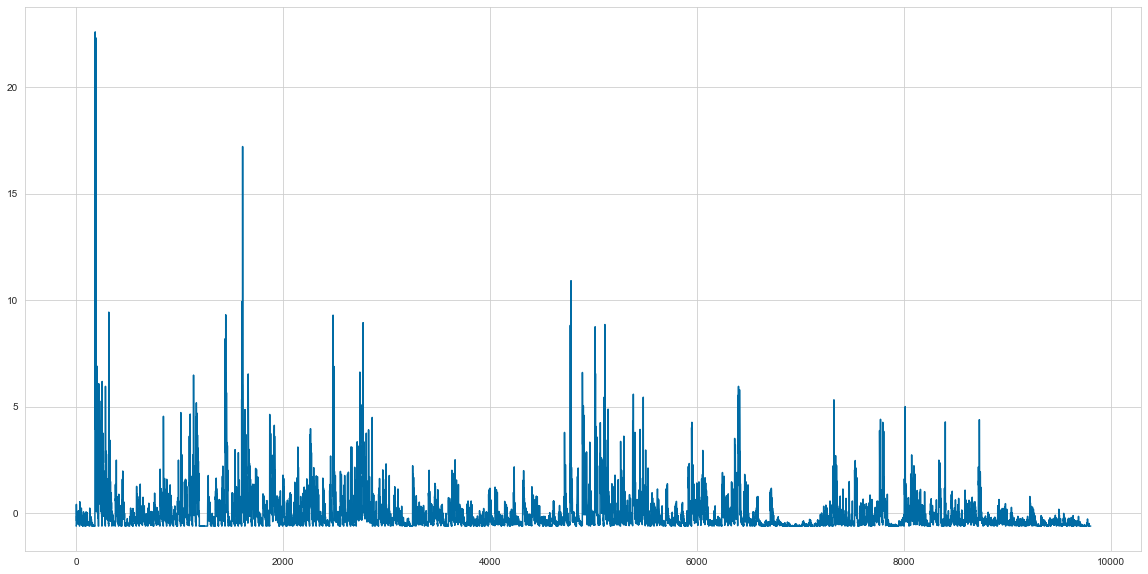

In [172]:
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

h=pd.DataFrame(b.values) # .sort_values('product_count'))

h_mean_norm = mean_norm(h)
plt.plot(h_mean_norm)

In [193]:
df

,product_id,store_id,date,product_count
0,5cebfa8d0b259700045dc8a9,5d5d24216115b3000435fa24,2022-01-01,0.0
4032,5d0794876885630014681bdd,5d5d24216115b3000435fa24,2022-01-01,0.0
508049,5ec3edb3bb5c330004014836,60f9974d4c35600015a5e6d8,2022-01-01,0.0
194040,5ebeb6c8dae8ef00043c366f,5fe3228d8babb6001700452b,2022-01-01,0.0
115044,5ebeb6c8dae8ef00043c366f,5f898d328fd8fa000492a14d,2022-01-01,0.0
...,...,...,...,...
150807,5d0794876885630014681bcc,5fca2dbdabdffb0004e1d05a,2022-06-17,0.0
15623,5ec3ee7bbb5c330004014839,5d5d24216115b3000435fa24,2022-06-17,0.0
860493,618bfaae48ced10016f399dc,615593694530bf0016cf2c56,2022-06-17,0.0
151191,5d83268bd8dd27c229979abf,5fca2dbdabdffb0004e1d05a,2022-06-17,0.0


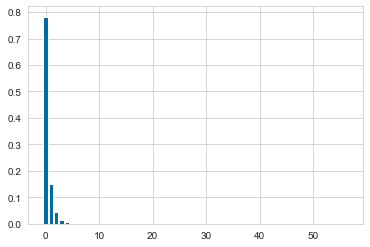

product_count
0.0     7.824255e-01
1.0     1.500489e-01
2.0     4.434851e-02
3.0     1.406629e-02
4.0     5.184635e-03
5.0     2.046824e-03
6.0     8.510480e-04
7.0     4.064268e-04
8.0     2.223106e-04
9.0     1.331905e-04
10.0    8.520273e-05
11.0    5.288446e-05
12.0    4.113235e-05
13.0    2.546289e-05
14.0    1.566947e-05
15.0    7.834734e-06
16.0    7.834734e-06
17.0    8.814076e-06
18.0    3.917367e-06
19.0    1.958684e-06
20.0    1.958684e-06
22.0    1.958684e-06
23.0    1.958684e-06
25.0    9.793418e-07
26.0    1.958684e-06
27.0    9.793418e-07
28.0    9.793418e-07
29.0    1.958684e-06
36.0    1.958684e-06
56.0    9.793418e-07
Name: tmp, dtype: float64

In [196]:
#get the mean
mean=b['product_count'].values.mean()
dfre = df[['product_count']]
dfre['tmp']=1
tmp =dfre.groupby('product_count')['tmp'].count()/len(dfre)
plt.bar(tmp.index,height=tmp)
#b.hist(bins=25) #changing the no. of bins to 25
#plt.axvline(mean,color='w',linestyle='dashed',linewidth='2')

plt.show()
tmp

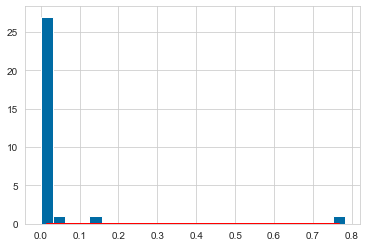

In [197]:
##poisson law of parameter mean

from scipy.optimize import curve_fit
from scipy.stats import poisson

# poisson function, parameter lamb is the fit parameter
def poisson_(k, lamb):
    return poisson.pmf(k=k, mu=lamb)



# the bins should be of integer width, because poisson is an integer distribution
entries, bin_edges, patches = plt.hist(tmp,bins=25)

# calculate binmiddles
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])


# fit with curve_fit

parameters, cov_matrix = curve_fit(poisson_,bin_middles,entries) 

# plot poisson-deviation with fitted parameter
x_plot = bin_middles #np.linspace(0, 20, 1200)

plt.plot(x_plot, poisson_(x_plot, *parameters), 'r-', lw=2)
plt.show()

#### Algorithmes

In [61]:
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
X= pd.concat([
    df['date'].dt.day,
    #df['date'].dt.month,
    df['date'].dt.weekday,
    df['date'].dt.weekofyear,
    df['product_id'],
    df['store_id']
],axis=1)
X.columns=['day','weekday','weekofyear','product_id','store_id']
# X['date']=df['date']
X=pd.get_dummies(X,columns=['product_id','store_id']).reset_index(drop=True)
X

,day,weekday,weekofyear,product_id_5cebfa8d0b259700045dc8a9,product_id_5cebfa8d0b259700045dc8aa,product_id_5cebfa8d0b259700045dc8ad,product_id_5cebfa8d0b259700045dc8b1,product_id_5cebfa8d0b259700045dc8b2,product_id_5cebfa8d0b259700045dc8b3,product_id_5cebfa8d0b259700045dc8b6,...,store_id_61843714e96267001600c425,store_id_61b0bd2f4f29eb0016bc17cc,store_id_620b8d72cc40e6001664d655,store_id_620bc7925dff3b00166e3ad4,store_id_620bc79e5dff3b00166e3d50,store_id_6213a22e1c8562001625c916,store_id_625010b6b4a6b10016f55883,store_id_625010c9b4a6b10016f55aff,store_id_62696bb7d8617800162c472a,store_id_627e47501f5ac0001658172d
0,1,5,52,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,5,52,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,5,52,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,5,52,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,5,52,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021089,17,4,24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1021090,17,4,24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1021091,17,4,24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1021092,17,4,24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
y=df[['product_count']].reset_index(drop=True)
y

,product_count
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
1021089,0.0
1021090,0.0
1021091,0.0
1021092,0.0


In [60]:
X_train=X[0:math.floor((1-test_size)*n)]
X_train

,day,weekday,weekofyear,product_id_5cebfa8d0b259700045dc8a9,product_id_5cebfa8d0b259700045dc8aa,product_id_5cebfa8d0b259700045dc8ad,product_id_5cebfa8d0b259700045dc8b1,product_id_5cebfa8d0b259700045dc8b2,product_id_5cebfa8d0b259700045dc8b3,product_id_5cebfa8d0b259700045dc8b6,...,store_id_61843714e96267001600c425,store_id_61b0bd2f4f29eb0016bc17cc,store_id_620b8d72cc40e6001664d655,store_id_620bc7925dff3b00166e3ad4,store_id_620bc79e5dff3b00166e3d50,store_id_6213a22e1c8562001625c916,store_id_625010b6b4a6b10016f55883,store_id_625010c9b4a6b10016f55aff,store_id_62696bb7d8617800162c472a,store_id_627e47501f5ac0001658172d
0,1,5,52,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4032,1,5,52,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
508049,1,5,52,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194040,1,5,52,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
115044,1,5,52,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496512,22,6,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
824493,22,6,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
825221,22,6,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
824721,22,6,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#split(data,label):
#train_min_date = series1['date'].min()
#train_max_date = '2022-05-10'
#test_min_date = train_max_date
#test_max_date = '2022-07-01'
import math
def split(X,y,test_size=0.2):
    n=X.shape[0]
    m=y.shape[0]
    X_train=X.iloc[0:math.floor((1-test_size)*n)]
    y_train=y.iloc[0:math.floor((1-test_size)*m)]
    X_test=X.iloc[math.floor((1-test_size)*n):n+1]
    y_test=y.iloc[math.floor((1-test_size)*m):m+1]
    return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test=split(X,y,test_size=0.2)
    

In [16]:
def metrics_(orig,preds):
    MSE=mean_squared_error(y_true=orig,
                   y_pred=preds)
    MAE=mean_absolute_error(y_true=orig,
                   y_pred=preds)
    MSLE=mean_squared_log_error(y_true=np.abs(orig),
                   y_pred=np.abs(preds))
    metrics = dict()
    metrics['MSE']= MSE
    metrics['MAE']= MAE
    metrics['MSLE']= MSLE
    return metrics

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
param = {
    'learning_rate': 0.022,
     'max_depth': 8,
     'min_impurity_decrease': 0.072,
     'min_samples_split': 31,
     'n_estimators': 100,
     'verbose':2
}

gbr_b = GradientBoostingRegressor(**param)
#Printing all the parameters of the model
print(gbr_b)
# Creating the model on Training Data
gbr_b.fit(X_train,y_train)


GradientBoostingRegressor(learning_rate=0.022, max_depth=8,
                          min_impurity_decrease=0.072, min_samples_split=31,
                          verbose=2)
      Iter       Train Loss   Remaining Time 
         1           0.6081           38.41m
         2           0.6047           37.14m
         3           0.6014           36.52m
         4           0.5983           34.89m
         5           0.5953           34.10m
         6           0.5924           35.21m
         7           0.5897           34.16m
         8           0.5870           33.11m
         9           0.5845           32.18m
        10           0.5821           31.29m
        11           0.5798           30.47m
        12           0.5777           29.68m
        13           0.5756           28.88m
        14           0.5734           28.20m
        15           0.5715           27.47m
        16           0.5695           27.09m
        17           0.5677           26.47m
        18     

GradientBoostingRegressor(learning_rate=0.022, max_depth=8,
                          min_impurity_decrease=0.072, min_samples_split=31,
                          verbose=2)

In [140]:
# Measuring Goodness of fit in Training data

print('R2 Value over the train set', r2_score(y_train, gbr_b.predict(X_train)))
print('R2 Value', gbr_b.score(X_train,y_train))
   
# score or coefficient of determination $R^2$ 
print('R2 Value over the test set',gbr_b.score(X_test, y_test))

R2 Value 0.17667394116505764
R2 Value 0.17667394116505764
0.17667394116505764


0.14669726736566202

In [132]:
prediction=gbr_b.predict(X_test)
metrics_hist=metrics_(y_test,prediction)
metrics_hist=pd.DataFrame([metrics_hist])
metrics_hist

,MSE,MAE,MSLE
0,0.502182,0.463741,0.131807


In [133]:
## tout depuis janv
subset = df [ (df.product_id == '5ebeb6c8dae8ef00043c366f') & (df.store_id == '5f898d328fd8fa000492a14d') ] #
# ou subset = df.query( '(product_id == '5ebeb6c8dae8ef00043c366f') & (store_id == '5f898d328fd8fa000492a14d')')
subset= subset.loc[:,['date','product_count']] #subset.drop(subset.columns[[0, 1]], axis = 1, inplace = True)

#plt.plot(subset['date'], subset['product_count'])
#subset

In [134]:

test_size=0.2
n=X.shape[0] #ou df.shape[0]


start_date=df['date'][math.floor((1-test_size)*n)]
print(start_date)
a=df
a=a.set_index('date')

result = a.truncate(before = start_date ) #, after = end_date) 

#reset index de result 
result=result.reset_index()  
subset2 = result [ (result.product_id == '5ebeb6c8dae8ef00043c366f') & (result.store_id == '5f898d328fd8fa000492a14d') ] 
# ou subset2=df.query( '(product_id == str(5ebeb6c8dae8ef00043c366f)) & (store_id == str(5f898d328fd8fa000492a14d))'& (df.index[df['date'] >= start_date])) 


subset2= subset2.loc[:,['date','product_count']] #subset2.drop(subset2.columns[[0, 1]], axis = 1, inplace = True) #drop aussi ancien_index 


2022-05-26 00:00:00


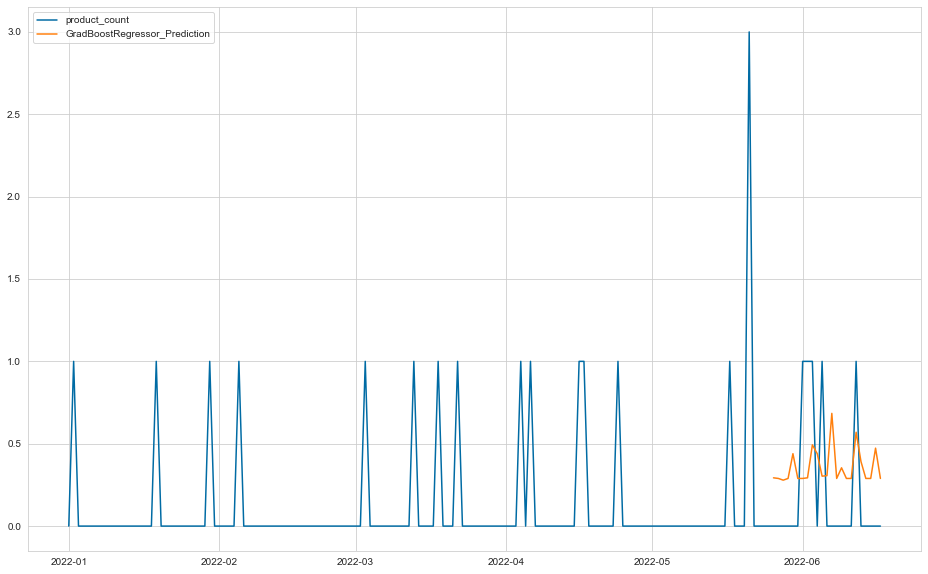

In [135]:
#date de prediction et valeurs
prediction=pd.DataFrame(prediction,columns=['preds'])
predict=prediction.loc[subset2.index.tolist()]  #recuperer les elts de prediction de meme index que celui de subset2.

# plot what has been learned

fig = plt.figure(1, figsize=(16, 10))
plt.plot(subset['date'], subset['product_count'])
plt.plot(subset2['date'], predict['preds'])  #ou predict.values ?
plt.legend(['product_count', 'GradBoostRegressor_Prediction'])
plt.show()

### Algorithm based on decision trees

### RandomForest

In [143]:
from sklearn.ensemble import RandomForestRegressor
 
# fit the model
rf = RandomForestRegressor(verbose=2)
rf.fit(X_train, y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 150.4min finished


RandomForestRegressor(verbose=2)

In [145]:
# predict on the same period
preds = rf.predict(X_train)

# Measuring Goodness of fit in Training data
print('R2 Value over the train set', r2_score(y_train, preds),rf.score(X_train,y_train))

# erreur de prévision sur le test
print('error Value over the test set',1 - rf.score(X_test,y_test))

prediction2=gbr_b.predict(X_test)
metrics_hist2=metrics_(y_test,prediction2)
metrics_hist2=pd.DataFrame([metrics_hist2])
metrics_hist2

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.1min finished


R2 Value over the train set 0.8827474761731517 0.8827474761731517


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   26.9s finished


error Value over the test set 0.9391481274301394


,MSE,MAE,MSLE
0,0.502182,0.463741,0.131807


In [152]:
# Importance des variables
importances = pd.DataFrame(
    rf.feature_importances_, 
    index = X_train.columns, 
    columns = ["importance"]
).sort_values(ascending = False, by = "importance")

importances

,importance
day,0.245306
weekofyear,0.178239
weekday,0.133592
product_id_5d0794866885630014681ba6,0.028930
store_id_5f898d328fd8fa000492a14d,0.019952
...,...
product_id_5f4d02823caafa00048b43d1,0.000000
product_id_5f4cf88ffb01e200046587ce,0.000000
product_id_5f4cf7cdfb01e200046587cb,0.000000
product_id_5f25738fd8cd3a0004584c71,0.000000


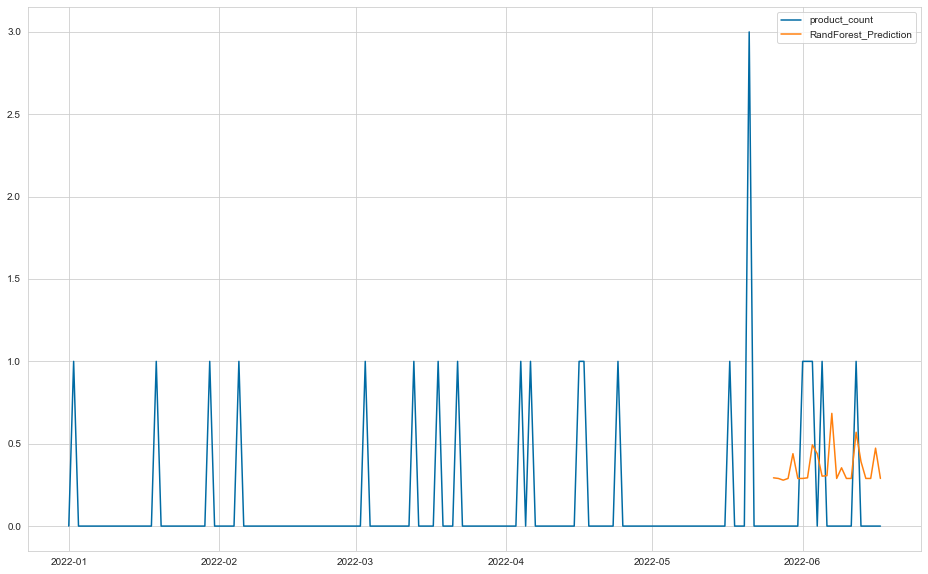

In [148]:
#date de prediction et valeurs
prediction2=pd.DataFrame(prediction2,columns=['preds'])
predict=prediction2.loc[subset2.index.tolist()]  #recuperer les elts de prediction de meme index que celui de subset2.

# plot what has been learned

fig = plt.figure(1, figsize=(16, 10))
plt.plot(subset['date'], subset['product_count'])
plt.plot(subset2['date'], predict['preds'])  #ou predict.values ?
plt.legend(['product_count', 'RandForest_Prediction'])
plt.show()

In [178]:
scaler=StandardScaler()  

In [179]:
scaler.fit(X_train)
X_train = pd.DataFrame(
    scaler.transform(X_train), 
    columns = X.columns, 
    index = X_train.index
) 
scaler.fit(X_test)
X_test = pd.DataFrame(
    scaler.transform(X_test), 
    columns = X.columns, 
    index = X_test.index
)

### XGBoost(EXtreme Gradient Boosting)

In [180]:
TargetVariable='product_count'
# Xtreme Gradient Boosting (XGBoost)
from xgboost import XGBRegressor
RegModel=XGBRegressor(max_depth=2, 
                      learning_rate=0.1, 
                      n_estimators=1000, 
                      verbose=2,
                      objective='reg:linear')
                      #booster='gbtree')

# Printing all the parameters of XGBoost
print(RegModel)

# Creating the model on Training Data
XGB=RegModel.fit(X_train,y_train)
prediction=XGB.predict(X_test)

from sklearn import metrics
# Measuring Goodness of fit in Training data
print('R2 Value:',metrics.r2_score(y_train, XGB.predict(X_train)))


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', predictor=None,
             random_state=None, reg_alpha=None, ...)
[13:16:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:01] WARNING: /Users/runner/work/xgboost/xgboost/pyt

NameError: name 'Predictors' is not defined


##### Model Validation and Accuracy Calculations ##########
              day   weekday  weekofyear  product_id_5cebfa8d0b259700045dc8a9  \
198125   0.688799  1.539869   -1.999173                            -0.011499   
826567   0.688799  1.539869   -1.999173                            -0.011499   
1015830  0.688799  1.539869   -1.999173                            -0.011499   
494357   0.688799  1.539869   -1.999173                            -0.011499   
825494   0.688799  1.539869   -1.999173                            -0.011499   

         product_id_5cebfa8d0b259700045dc8aa  \
198125                             -0.064497   
826567                             -0.064497   
1015830                            -0.064497   
494357                             -0.064497   
825494                             -0.064497   

         product_id_5cebfa8d0b259700045dc8ad  \
198125                             -0.064802   
826567                             -0.064802   
1015830                  

KeyError: 'MEDV'

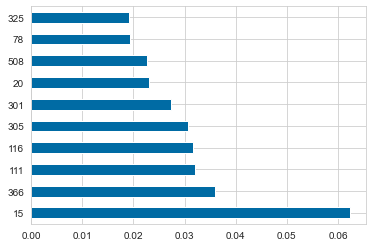

In [182]:
Predictors=['registered', 'mnth', 'hr', 'weekday']
# Plotting the feature importance for Top 10 most important columns
%matplotlib inline
feature_importances = pd.Series(XGB.feature_importances_) #, index=Predictors)
feature_importances.nlargest(10).plot(kind='barh')
###########################################################################
print('\n##### Model Validation and Accuracy Calculations ##########')

# Printing some sample values of prediction
TestingDataResults=pd.DataFrame(data=X_test) #, columns=Predictors)
TestingDataResults[TargetVariable]=y_test
TestingDataResults[('Predicted'+TargetVariable)]=np.round(prediction)

# Printing sample prediction values
print(TestingDataResults.head())

# Calculating the error for each row
TestingDataResults['APE']=100 * ((abs(
  TestingDataResults['MEDV']-TestingDataResults['PredictedMEDV']))/TestingDataResults['MEDV'])


MAPE=np.mean(TestingDataResults['APE'])
MedianMAPE=np.median(TestingDataResults['APE'])

Accuracy =100 - MAPE
MedianAccuracy=100- MedianMAPE
print('Mean Accuracy on test data:', Accuracy) # Can be negative sometimes due to outlier
print('Median Accuracy on test data:', MedianAccuracy)


# Defining a custom function to calculate accuracy
# Make sure there are no zeros in the Target variable if you are using MAPE
def Accuracy_Score(orig,pred):
    MAPE = np.mean(100 * (np.abs(orig-pred)/orig))
    #print('#'*70,'Accuracy:', 100-MAPE)
    return(100-MAPE)

# Custom Scoring MAPE calculation
from sklearn.metrics import make_scorer
custom_Scoring=make_scorer(Accuracy_Score, greater_is_better=True)

# Importing cross validation function from sklearn
from sklearn.model_selection import cross_val_score

# Running 10-Fold Cross validation on a given algorithm
# Passing full data X and y because the K-fold will split the data and automatically choose train/test
Accuracy_Values=cross_val_score(RegModel, X , y, cv=10, scoring=custom_Scoring)
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))

### Plotting a single Decision tree out of XGBoost

In [ ]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 8))
plot_tree(XGB, num_trees=10, ax=ax)

In [ ]:
#Le paramètre de pénalisation lasso est optimisé par validation croisée.

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

# grille de valeurs du paramètre alpha à optimiser
grid =[{"alpha":[0.05,0.1,0.2,0.3,0.4,0.5,1]}]

model = GridSearchCV(linear_model.Lasso(), grid, cv = 5)

model = model.fit(X_train, y_train)

# paramètre optimal
model.best_params_["alpha"]

f"Meilleur R2 = {model.best_score_}, Meilleur paramètre = {model.best_params_}"

In [ ]:
y_pred = model.predict(X_test)
print(f"MSE: {mean_squared_error(y_pred, y_test):4f}")
print(f"R2 : {r2_score(y_test, y_pred):4f}")

plt.plot(y_pred, y_test,"o")
plt.xlabel(u"O3 Prédite")
plt.ylabel("O3 observee")
plt.show()

In [ ]:
# Coefficients
model = linear_model.Lasso(alpha=model.best_params_['alpha'])
model = model.fit(X_train, y_train)
model.coef_

In [ ]:
coef = pd.Series(model.coef_, index = X_train.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))

In [ ]:
from sklearn.neural_network import MLPRegressor 

grid = [{"hidden_layer_sizes":list([(5,),(6,),(7,),(8,)])}]

neural_network = GridSearchCV(
    MLPRegressor(max_iter=1000, warm_start=True, random_state=42),
    grid,
    cv = 10,
)

neural_network = neural_network.fit(X_train, y_train)


In [ ]:
# paramètre optimal
f"Meilleur score = {1.- neural_network.best_score_:f}, meilleur paramètre: {neural_network.best_params_}"

# Estimation de l'erreur de prévision sur le test
1 - neural_network.score(X_test, y_test)

In [ ]:
# prévision de l'échantillon test
y_pred = neural_network.predict(X_test)

# matrice de confusion
pd.crosstab(y_pred, y_test)

In [ ]:

from sklearn.svm import SVC

grid = [{"C":[0.4,0.5,0.6,0.8,1,1.4]}]

svm = GridSearchCV(
    SVC(random_state = 42),
    grid,
    cv=10
)

svm = svm.fit(X_train, y_train)



In [ ]:
# paramètre optimal
f"Meilleur score: {1.- svm.best_score_:f}, meilleur paramètre: {svm.best_params_}"

# erreur de prévision sur le test
1 - svm.score(X_test, y_test)

# prévision de l'échantillon test
y_pred = svm.predict(X_test)

# matrice de confusion
pd.crosstab(y_pred, y_test)

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(iris.data, iris.target)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})  ###

sorted(clf.cv_results_.keys())




#### Synthèse: comparaison des méthodes

In [ ]:
from sklearn.metrics import roc_curve

methods = {
    "random_forest": random_forest,
    "neural_netork": neural_network,
    "decision_tree": decision_tree,
}

In [ ]:
for method, model in methods.items():
    
    model = model.fit(X_train, y_train)
    
    probas_ = model.predict_proba(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, probas_[:,1])
    
    plt.plot(fpr, tpr, lw = 1,label = method)
    
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.legend(loc="best")
plt.show()

In [ ]:

dateString=series2['start_date'][403].strftime('%Y-%m-%d')
print(dateString)
print(datetime.strptime(dateString,'%Y-%m-%d'))
print(datetime.date(datetime.strptime(dateString,'%Y-%m-%d')))

from datetime import datetime

now = datetime.now() # current date and time

year = now.strftime("%Y")
print("year:", year)

month = now.strftime("%m")
print("month:", month)

day = now.strftime("%d")
print("day:", day)

time = now.strftime("%H:%M:%S")
print("time:", time)

date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
print("date and time:",date_time)	

